In [ ]:
#pip install torch torchvision transformers pandas numpy tqdm pillow


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from transformers import AutoTokenizer, AutoModel, ViTModel
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
import pandas as pd
import os


In [3]:
# Load Dataset
df = pd.read_csv("/kaggle/input/preprocessed-2503/preprocessed_data_task2_2503.csv") 
df.head(1)

,Unnamed: 0,id_EXIST,lang,text,meme,path_memes,number_annotators,annotators,labels_task2_2,final_labels_task2_2
0,0,110001,es,2+2=5 MITO Albert Einstein tenía bajo rendimie...,110001.jpeg,/kaggle/input/memes-dataset/memes/110001.jpeg,6,"['Annotator_1', 'Annotator_2', 'Annotator_3', ...","['DIRECT', 'DIRECT', 'DIRECT', 'DIRECT', 'DIRE...",DIRECT


In [4]:
# Convert labels to a single integer column (0 for NO, 1 for YES)
df['label'] = df['final_labels_task2_2'].map({'DIRECT': 1, 'JUDGEMENTAL': 0})


In [6]:
df.drop(columns=['number_annotators'],axis=1,inplace=True)

In [7]:
df.head()

,Unnamed: 0,id_EXIST,lang,text,meme,path_memes,annotators,labels_task2_2,final_labels_task2_2,label
0,0,110001,es,2+2=5 MITO Albert Einstein tenía bajo rendimie...,110001.jpeg,/kaggle/input/memes-dataset/memes/110001.jpeg,"['Annotator_1', 'Annotator_2', 'Annotator_3', ...","['DIRECT', 'DIRECT', 'DIRECT', 'DIRECT', 'DIRE...",DIRECT,1.0
1,1,110002,es,CUANDO UNA MUJER VA A LUCHAR POR SUS DERECHOS,110002.jpeg,/kaggle/input/memes-dataset/memes/110002.jpeg,"['Annotator_1', 'Annotator_2', 'Annotator_3', ...","['DIRECT', 'DIRECT', 'DIRECT', 'DIRECT', 'DIRE...",DIRECT,1.0
2,2,110003,es,ІЯ ЕГЕЯ Е MOA ¿El Partido Republicano busca pe...,110003.jpeg,/kaggle/input/memes-dataset/memes/110003.jpeg,"['Annotator_1', 'Annotator_2', 'Annotator_3', ...","['DIRECT', 'DIRECT', '-', '-', '-', '-']",DIRECT,1.0
3,3,110004,es,"Paises que ""apoyan"" los derechos de la mujer A...",110004.jpeg,/kaggle/input/memes-dataset/memes/110004.jpeg,"['Annotator_1', 'Annotator_2', 'Annotator_3', ...","['JUDGEMENTAL', 'JUDGEMENTAL', '-', '-', 'JUDG...",JUDGEMENTAL,0.0
4,4,110006,es,"Princesa, hoy es tu día, no laves ningún plato...",110006.jpeg,/kaggle/input/memes-dataset/memes/110006.jpeg,"['Annotator_1', 'Annotator_2', 'Annotator_3', ...","['DIRECT', 'DIRECT', 'DIRECT', 'DIRECT', 'DIRE...",DIRECT,1.0


In [8]:
df['label'].value_counts()

label
1.0    2503
0.0    1148
Name: count, dtype: int64

In [10]:

print(df['final_labels_task2_2'].value_counts())

final_labels_task2_2
DIRECT         2503
JUDGEMENTAL    1148
Name: count, dtype: int64


In [12]:

#df.count()


In [15]:
df['label'].value_counts()

label
1.0    2503
0.0    1148
Name: count, dtype: int64

In [21]:
print(df["label"].isna().sum())  # Count NaN values
df_balanced = df_balanced.dropna(subset=["label"])

df_balanced["label"] = df_balanced["label"].astype(int)


377


<ipython-input-21-4292a5baf029>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_balanced["label"] = df_balanced["label"].astype(int)


In [23]:
from sklearn.model_selection import train_test_split

# Ensure equal samples for "en" & "es"
min_count = df["lang"].value_counts().min()  # Get minimum count across languages

# Fix groupby sampling issue
df_balanced = df.groupby("lang", group_keys=False).apply(lambda x: x.sample(min_count)).reset_index(drop=True)

# Check for NaNs
print("NaN values in 'label' before cleanup:", df_balanced["label"].isna().sum())

# Drop NaNs
df_balanced = df_balanced.dropna(subset=["label"])

# Ensure 'label' is numeric
df_balanced["label"] = df_balanced["label"].astype(int)

# Check again for NaNs
print("NaN values in 'label' after cleanup:", df_balanced["label"].isna().sum())

# Train-test split
train_df, temp_df = train_test_split(df_balanced, test_size=0.2, stratify=df_balanced["label"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.33, stratify=temp_df["label"], random_state=42)  # 20% val, 10% test

print("Data split complete!")


NaN values in 'label' before cleanup: 374
NaN values in 'label' after cleanup: 0
Data split complete!


<ipython-input-23-0ccd77a6b771>:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby("lang", group_keys=False).apply(lambda x: x.sample(min_count)).reset_index(drop=True)


In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [25]:
vit_model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k").to(device)
bert_model = AutoModel.from_pretrained("bert-base-uncased").to(device)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [26]:
def process_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resizes image
        transforms.ToTensor(),  # Converts to PyTorch tensor
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalization
    ])
    image = Image.open(image_path).convert("RGB")  # Open as RGB
    return transform(image)


In [27]:
def process_text(text):
    encoded = tokenizer(
        text,
        padding="max_length",  # Pads
        truncation=True,  # Cuts longer text
        max_length=40,  # Maximum token length
        return_tensors="pt"
    )
    return {key: val.to(device) for key, val in encoded.items()}


In [28]:
class MemeDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.image_transform = transforms.Compose([
            transforms.Resize((224, 224)),  # Resize images
            transforms.ToTensor(),  # Convert images to tensors
        ])
    
    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image = process_image(row["path_memes"])  # Process image
        text = row["text"]  # Get text
        label = torch.tensor(row["label"], dtype=torch.long)  # Convert label to tensor
        
        return {
            "image": image.to(device),
            "text": text,
            "label": label.to(device)
        }


In [29]:
train_loader = DataLoader(MemeDataset(train_df), batch_size=8, shuffle=True)
val_loader = DataLoader(MemeDataset(val_df), batch_size=8, shuffle=False)
test_loader = DataLoader(MemeDataset(test_df), batch_size=8, shuffle=False)


In [30]:
class MemeClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super(MemeClassifier, self).__init__()
        self.vit = vit_model  # Vision Transformer
        self.bert = bert_model  # BERT for text
        
        # Fully Connected Layer (Combining Image + Text Features)
        self.fc = nn.Linear(self.vit.config.hidden_size + self.bert.config.hidden_size, num_classes)

    def forward(self, image, text):
        if len(image.shape) == 3:  # If image is (3, 224, 224), add batch dimension
            image = image.unsqueeze(0)  # Becomes (1, 3, 224, 224)
    
        image_features = self.vit(image)['last_hidden_state'][:, 0, :]  # Shape: (batch_size, hidden_dim)
        text_features = self.bert(**process_text(text))["last_hidden_state"][:, 0, :]  # Shape: (batch_size, hidden_dim)
    
        combined_features = torch.cat((image_features, text_features), dim=-1)  # Concatenate along last dim
        logits = self.fc(combined_features)  # Classification Head
        return logits




In [31]:
model = MemeClassifier(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()  # Standard loss function for classification
optimizer = optim.AdamW(model.parameters(), lr=2e-5)  # Optimizer


In [33]:
import torch

num_epochs = 30
checkpoint_path = "/kaggle/working/best_model_checkpoint.pth"

# Lists to store training & validation accuracy/loss
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

best_val_acc = 0.0  # Track the best validation accuracy

for epoch in range(num_epochs):
    ###################################
    # -------- Training Phase --------#
    ###################################
    model.train()
    train_loss, correct_train, total_train = 0, 0, 0
    
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, texts, labels = batch["image"], batch["text"], batch["label"]
        
        optimizer.zero_grad()
        outputs = model(images, texts)  # Forward Pass
        loss = criterion(outputs, labels)  # Compute Loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update Weights
        
        train_loss += loss.item()
        correct_train += (outputs.argmax(1) == labels).sum().item()
        total_train += labels.size(0)
    
    train_accuracy = correct_train / total_train
    avg_train_loss = train_loss / len(train_loader)

    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    
    ######################################
    # -------- Validation Phase --------#
    ######################################
    model.eval()
    val_loss, correct_val, total_val = 0, 0, 0
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images, texts, labels = batch["image"], batch["text"], batch["label"]
            outputs = model(images, texts)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            correct_val += (outputs.argmax(1) == labels).sum().item()
            total_val += labels.size(0)

    val_accuracy = correct_val / total_val
    avg_val_loss = val_loss / len(val_loader)

    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2%} | "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2%}")
    
    # Save the best model checkpoint (when val accuracy improves)
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy  # Update best validation accuracy
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accuracies': train_accuracies,
            'val_accuracies': val_accuracies,
            'best_val_acc': best_val_acc
        }, checkpoint_path)
        
        print(f"New best model saved with Validation Accuracy: {val_accuracy:.2%}")

print("Training & Validation Complete! Best model checkpoint saved at", checkpoint_path)


Epoch 1/30 - Validation: 100%|██████████| 61/61 [00:10<00:00,  5.81it/s]


Epoch 1: Train Loss: 0.4393, Train Acc: 79.55% | Val Loss: 0.6789, Val Acc: 65.02%
New best model saved with Validation Accuracy: 65.02%


Epoch 2/30 - Validation: 100%|██████████| 61/61 [00:10<00:00,  5.79it/s]


Epoch 2: Train Loss: 0.1856, Train Acc: 93.97% | Val Loss: 0.7917, Val Acc: 64.20%


Epoch 3/30 - Validation: 100%|██████████| 61/61 [00:10<00:00,  5.72it/s]


Epoch 3: Train Loss: 0.0713, Train Acc: 98.21% | Val Loss: 1.2730, Val Acc: 63.99%


Epoch 4/30 - Validation: 100%|██████████| 61/61 [00:10<00:00,  5.80it/s]


Epoch 4: Train Loss: 0.0392, Train Acc: 99.10% | Val Loss: 1.3930, Val Acc: 58.44%


Epoch 5/30 - Validation: 100%|██████████| 61/61 [00:10<00:00,  5.80it/s]


Epoch 5: Train Loss: 0.0241, Train Acc: 99.31% | Val Loss: 1.3895, Val Acc: 63.37%


Epoch 6/30 - Validation: 100%|██████████| 61/61 [00:10<00:00,  5.79it/s]


Epoch 6: Train Loss: 0.0285, Train Acc: 98.90% | Val Loss: 1.3920, Val Acc: 61.32%


Epoch 7/30 - Validation: 100%|██████████| 61/61 [00:10<00:00,  5.70it/s]


Epoch 7: Train Loss: 0.0452, Train Acc: 98.35% | Val Loss: 1.4082, Val Acc: 63.17%


Epoch 8/30 - Validation: 100%|██████████| 61/61 [00:10<00:00,  5.67it/s]


Epoch 8: Train Loss: 0.0298, Train Acc: 98.97% | Val Loss: 1.5392, Val Acc: 56.17%


Epoch 9/30 - Validation: 100%|██████████| 61/61 [00:10<00:00,  5.69it/s]


Epoch 9: Train Loss: 0.0140, Train Acc: 99.45% | Val Loss: 1.6239, Val Acc: 61.32%


Epoch 10/30 - Validation: 100%|██████████| 61/61 [00:10<00:00,  6.04it/s]


Epoch 10: Train Loss: 0.0109, Train Acc: 99.48% | Val Loss: 1.7214, Val Acc: 62.14%


Epoch 11/30 - Validation: 100%|██████████| 61/61 [00:10<00:00,  6.01it/s]


Epoch 11: Train Loss: 0.0095, Train Acc: 99.41% | Val Loss: 1.7711, Val Acc: 61.52%


Epoch 12/30 - Validation: 100%|██████████| 61/61 [00:10<00:00,  5.93it/s]


Epoch 12: Train Loss: 0.0093, Train Acc: 99.38% | Val Loss: 1.8204, Val Acc: 62.96%


Epoch 13/30 - Validation: 100%|██████████| 61/61 [00:10<00:00,  5.95it/s]


Epoch 13: Train Loss: 0.0088, Train Acc: 99.45% | Val Loss: 1.8256, Val Acc: 63.99%


Epoch 14/30 - Validation: 100%|██████████| 61/61 [00:10<00:00,  5.96it/s]


Epoch 14: Train Loss: 0.0085, Train Acc: 99.45% | Val Loss: 1.9355, Val Acc: 62.14%


Epoch 15/30 - Validation: 100%|██████████| 61/61 [00:10<00:00,  5.96it/s]


Epoch 15: Train Loss: 0.0082, Train Acc: 99.35% | Val Loss: 1.9443, Val Acc: 62.76%


Epoch 16/30 - Validation: 100%|██████████| 61/61 [00:10<00:00,  5.78it/s]


Epoch 16: Train Loss: 0.0090, Train Acc: 99.48% | Val Loss: 1.7247, Val Acc: 66.26%
New best model saved with Validation Accuracy: 66.26%


Epoch 17/30 - Validation: 100%|██████████| 61/61 [00:10<00:00,  6.04it/s]


Epoch 17: Train Loss: 0.0742, Train Acc: 97.28% | Val Loss: 1.5072, Val Acc: 58.23%


Epoch 18/30 - Validation: 100%|██████████| 61/61 [00:10<00:00,  5.97it/s]


Epoch 18: Train Loss: 0.0282, Train Acc: 98.79% | Val Loss: 1.9190, Val Acc: 63.99%


Epoch 19/30 - Validation: 100%|██████████| 61/61 [00:10<00:00,  6.02it/s]


Epoch 19: Train Loss: 0.0179, Train Acc: 99.24% | Val Loss: 1.8494, Val Acc: 60.70%


Epoch 20/30 - Validation: 100%|██████████| 61/61 [00:10<00:00,  6.04it/s]


Epoch 20: Train Loss: 0.0099, Train Acc: 99.41% | Val Loss: 1.6842, Val Acc: 60.08%


Epoch 21/30 - Validation: 100%|██████████| 61/61 [00:10<00:00,  6.00it/s]


Epoch 21: Train Loss: 0.0087, Train Acc: 99.45% | Val Loss: 1.9810, Val Acc: 62.55%


Epoch 22/30 - Validation: 100%|██████████| 61/61 [00:10<00:00,  5.98it/s]


Epoch 22: Train Loss: 0.0079, Train Acc: 99.45% | Val Loss: 2.1149, Val Acc: 61.73%


Epoch 23/30 - Validation: 100%|██████████| 61/61 [00:10<00:00,  5.93it/s]


Epoch 23: Train Loss: 0.0075, Train Acc: 99.45% | Val Loss: 2.1850, Val Acc: 61.52%


Epoch 24/30 - Validation: 100%|██████████| 61/61 [00:10<00:00,  5.84it/s]


Epoch 24: Train Loss: 0.0079, Train Acc: 99.35% | Val Loss: 2.2246, Val Acc: 61.52%


Epoch 25/30 - Validation: 100%|██████████| 61/61 [00:10<00:00,  5.85it/s]


Epoch 25: Train Loss: 0.0076, Train Acc: 99.41% | Val Loss: 2.2133, Val Acc: 58.23%


Epoch 26/30 - Validation: 100%|██████████| 61/61 [00:10<00:00,  5.96it/s]


Epoch 26: Train Loss: 0.0074, Train Acc: 99.35% | Val Loss: 2.3115, Val Acc: 59.88%


Epoch 27/30 - Validation: 100%|██████████| 61/61 [00:10<00:00,  5.97it/s]


Epoch 27: Train Loss: 0.0074, Train Acc: 99.35% | Val Loss: 2.3082, Val Acc: 60.08%


Epoch 28/30 - Validation: 100%|██████████| 61/61 [00:10<00:00,  5.99it/s]


Epoch 28: Train Loss: 0.0074, Train Acc: 99.38% | Val Loss: 2.4390, Val Acc: 63.17%


Epoch 29/30 - Validation: 100%|██████████| 61/61 [00:10<00:00,  5.94it/s]


Epoch 29: Train Loss: 0.0110, Train Acc: 99.24% | Val Loss: 1.9424, Val Acc: 59.88%


Epoch 30/30 - Validation: 100%|██████████| 61/61 [00:10<00:00,  5.95it/s]

Epoch 30: Train Loss: 0.0771, Train Acc: 97.14% | Val Loss: 1.7612, Val Acc: 58.85%
Training & Validation Complete! Best model checkpoint saved at /kaggle/working/best_model_checkpoint.pth


In [4]:
import os
import json
import torch
import pandas as pd
from tqdm import tqdm
from PIL import Image
from torch import nn
from torchvision import transforms
from transformers import ViTModel, AutoModel, AutoTokenizer

# 1) Config & paths
DEVICE          = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CHECKPOINT_PATH = "/kaggle/input/checkpoint-task2/best_model_checkpoint.pth"
TEST_CSV_PATH   = "/kaggle/input/testing-clef-task2/testing_with_labels.csv"
OUTPUT_JSON     = "/kaggle/working/results.json"

# 2) Load pretrained backbones + tokenizer
vit_model  = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
bert_model = AutoModel.from_pretrained("bert-base-uncased")
tokenizer  = AutoTokenizer.from_pretrained("bert-base-uncased")

# 3) Define your multimodal classifier
class MemeClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.vit  = vit_model
        self.bert = bert_model
        self.fc   = nn.Linear(
            self.vit.config.hidden_size + self.bert.config.hidden_size,
            num_classes
        )
    def forward(self, img, text_inputs):
        img_feats = self.vit(img).last_hidden_state[:,0,:]
        txt_feats = self.bert(**text_inputs).last_hidden_state[:,0,:]
        feats     = torch.cat([img_feats, txt_feats], dim=-1)
        return self.fc(feats)

# 4) Preprocessing
image_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),
])

def preprocess_image(path):
    img = Image.open(path).convert("RGB")
    return image_transform(img).unsqueeze(0).to(DEVICE)

def preprocess_text(text):
    enc = tokenizer(
        text,
        padding="max_length",
        truncation=True,
        max_length=40,
        return_tensors="pt"
    )
    return {k:v.to(DEVICE) for k,v in enc.items()}

# 5) Load test CSV
df = pd.read_csv(TEST_CSV_PATH)

# 6) Build model + load checkpoint
model = MemeClassifier(num_classes=2).to(DEVICE)
ckpt  = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
model.load_state_dict(ckpt["model_state_dict"])
model.eval()

# 7) Label mapping
idx2label = {1: "DIRECT", 0: "JUDGEMENTAL"}

# 8) Inference
results = []
for _, row in tqdm(df.iterrows(), total=len(df)):
    rec = {
        "test_case": "EXIST2025",
        "id": str(row["id_EXIST"])
    }

    # If ground-truth says NO, skip model call
    if str(row["label"]).strip().upper() == "NO":
        rec["value"] = "NO"
    else:
        img_tensor  = preprocess_image(row["path_memes"])
        text_inputs = preprocess_text(row["text"])
        with torch.no_grad():
            logits = model(img_tensor, text_inputs)
            pred   = logits.argmax(dim=-1).item()
        rec["value"] = idx2label[pred]

    results.append(rec)

# 9) Save + print JSON
with open(OUTPUT_JSON, "w") as f:
    json.dump(results, f, indent=4)

print(json.dumps(results, indent=4))
print(f"\nResults written to {OUTPUT_JSON}")


<ipython-input-4-a8d1c70cfdca>:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt  = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
100%|██████████| 1053/1053 [00:26<0

[
    {
        "test_case": "EXIST2025",
        "id": "310001",
        "value": "NO"
    },
    {
        "test_case": "EXIST2025",
        "id": "310002",
        "value": "DIRECT"
    },
    {
        "test_case": "EXIST2025",
        "id": "310003",
        "value": "DIRECT"
    },
    {
        "test_case": "EXIST2025",
        "id": "310004",
        "value": "DIRECT"
    },
    {
        "test_case": "EXIST2025",
        "id": "310005",
        "value": "DIRECT"
    },
    {
        "test_case": "EXIST2025",
        "id": "310006",
        "value": "NO"
    },
    {
        "test_case": "EXIST2025",
        "id": "310007",
        "value": "DIRECT"
    },
    {
        "test_case": "EXIST2025",
        "id": "310008",
        "value": "DIRECT"
    },
    {
        "test_case": "EXIST2025",
        "id": "310009",
        "value": "DIRECT"
    },
    {
        "test_case": "EXIST2025",
        "id": "310010",
        "value": "DIRECT"
    },
    {
        "test_case": "EXIST202

In [ ]:
# import torch

# num_epochs = 30

# # Lists to store training & validation accuracy/loss
# train_losses, val_losses = [], []
# train_accuracies, val_accuracies = [], []

# for epoch in range(num_epochs):
#     ###################################
#     # -------- Training Phase --------#
#     ###################################
#     model.train()
#     train_loss, correct_train, total_train = 0, 0, 0
    
#     for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
#         images, texts, labels = batch["image"], batch["text"], batch["label"]
        
#         optimizer.zero_grad()
#         outputs = model(images, texts)  # Forward Pass
#         loss = criterion(outputs, labels)  # Compute Loss
#         loss.backward()  # Backpropagation
#         optimizer.step()  # Update Weights
        
#         train_loss += loss.item()
#         correct_train += (outputs.argmax(1) == labels).sum().item()
#         total_train += labels.size(0)
    
#     train_accuracy = correct_train / total_train
#     avg_train_loss = train_loss / len(train_loader)

#     train_losses.append(avg_train_loss)
#     train_accuracies.append(train_accuracy)
#     ######################################
#     # -------- Validation Phase --------###
#     #####################################
#     model.eval()
#     val_loss, correct_val, total_val = 0, 0, 0
    
#     with torch.no_grad():
#         for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
#             images, texts, labels = batch["image"], batch["text"], batch["label"]
#             outputs = model(images, texts)
#             loss = criterion(outputs, labels)

#             val_loss += loss.item()
#             correct_val += (outputs.argmax(1) == labels).sum().item()
#             total_val += labels.size(0)

#     val_accuracy = correct_val / total_val
#     avg_val_loss = val_loss / len(val_loader)

#     val_losses.append(avg_val_loss)
#     val_accuracies.append(val_accuracy)

#     print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2%} | "
#           f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2%}")

# print("Training & Validation Complete!")

In [ ]:
!ls /kaggle/working/checkpoints

In [34]:
# Testing the Model
model.eval()
correct_test, total_test = 0, 0

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        images, texts, labels = batch["image"], batch["text"], batch["label"]
        outputs = model(images, texts)
        
        predicted = outputs.argmax(1)
        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)

test_accuracy = correct_test / total_test
print(f"Test Accuracy: {test_accuracy:.2%}")


Testing: 100%|██████████| 30/30 [00:07<00:00,  4.27it/s]

Test Accuracy: 61.67%


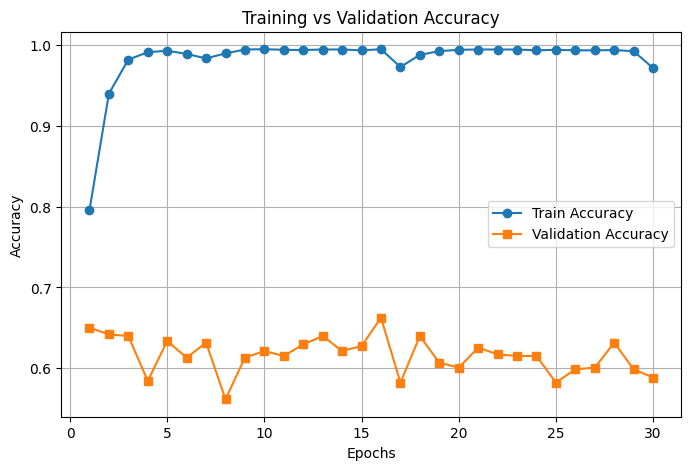

In [36]:
import matplotlib.pyplot as plt
def plot_accuracy(train_acc, val_acc):
    """
    Plots Training and Validation Accuracy.
    """
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(train_acc) + 1), train_acc, label='Train Accuracy', marker='o')
    plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy', marker='s')

    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()
    plt.grid()
    plt.show()
plot_accuracy(train_accuracies, val_accuracies)

#### End to End Pipeline

In [2]:
!pip install gradio --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 MB 29.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 91.3 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.5 MB/s eta 0:00:00


In [41]:
from transformers import MarianMTModel, MarianTokenizer


In [49]:
# ocr works better on high contrast image (grey) convert image rcb to grey then apply ocr

In [52]:
import cv2
print(cv2.__version__)

4.10.0


In [4]:
import cv2
import torch
import gradio as gr
import easyocr
from transformers import MarianMTModel, MarianTokenizer, ViTModel, BertModel, AutoTokenizer
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torch.optim as optim

# Load OCR model (EasyOCR)
ocr_reader = easyocr.Reader(['en', 'es'])

# Load translation model (MarianMT)
model_name = "Helsinki-NLP/opus-mt-es-en"
translator = MarianMTModel.from_pretrained(model_name)
tokenizer = MarianTokenizer.from_pretrained(model_name)

# Load vision and text models
vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
bert_model = BertModel.from_pretrained('GroNLP/hateBERT')
bert_tokenizer = AutoTokenizer.from_pretrained('GroNLP/hateBERT')


#  Image Preprocessing for OCR
def preprocess_image(image):
    """Convert image to grayscale and enhance contrast for better OCR."""
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
    image = cv2.GaussianBlur(image, (5,5), 0)  # Reduce noise
    image = cv2.equalizeHist(image)  # Improve contrast
    return image

#  OCR Extraction with Improved Processing
def ocr_extract(image):
    """Extract text from enhanced image using EasyOCR."""
    preprocessed_image = preprocess_image(image)
    result = ocr_reader.readtext(preprocessed_image, detail=0, paragraph=True)
    return " ".join(result)


def translate_text(text, lang):
    """Translate Spanish text to English using MarianMT."""
    if lang == "Spanish":
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
        translated = translator.generate(**inputs)
        text = tokenizer.decode(translated[0], skip_special_tokens=True)
    return text

def process_text(text):
    """Tokenize text for BERT."""
    return bert_tokenizer(text, return_tensors="pt", padding=True, truncation=True).to(device)

class MemeClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super(MemeClassifier, self).__init__()
        self.vit = vit_model  # Vision Transformer
        self.bert = bert_model  # BERT for text
        self.fc = nn.Linear(self.vit.config.hidden_size + self.bert.config.hidden_size, num_classes)

    def forward(self, image, text):
        image_features = self.vit(image)['last_hidden_state'][:, 0, :]
        text_features = self.bert(**text)["last_hidden_state"][:, 0, :]
        combined_features = torch.cat((image_features, text_features), dim=-1)
        logits = self.fc(combined_features)
        return logits

# Load the trained model checkpoint
checkpoint_path = "/kaggle/input/checkpoint-task2/best_model_checkpoint.pth"
model = MemeClassifier()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

def classify_meme(image, language):
    """Full pipeline: OCR -> Translate -> Predict"""
    extracted_text = ocr_extract(image)
    processed_text = translate_text(extracted_text, language)
    tokenized_text = process_text(processed_text)  # Convert text to tensor
    processed_image = process_image(image).to(device)

    with torch.no_grad():
        output = model(processed_image.unsqueeze(0), tokenized_text)
        prediction = torch.argmax(output, dim=1).item()
        result = "Direct" if prediction == 1 else "Judgmental"

    
    return result #extracted_text, processed_text,

# Image processing function
def process_image(image):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    image = Image.fromarray(image).convert("RGB")
    return transform(image)

# Gradio UI
gui = gr.Interface(
    fn=classify_meme,
    inputs=[
        gr.Image(type='numpy', label="Upload Meme"),
        gr.Dropdown(choices=["English", "Spanish"], label="Text Language", value="English")
    ],
    outputs=[
        #  gr.Textbox(label="Extracted Text"),
        # gr.Textbox(label="Translated Text (if applicable)"),
        gr.Label(label="Classification Result")
    ],
    title="Meme Classifier",
    description="Upload a meme. The system classifies it as 'Direct' or 'Judgmental'."
)



gui.launch()


/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
<ipython-input-4-605ba1d35f44>:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full contr

* Running on local URL:  http://127.0.0.1:7861
Kaggle notebooks require sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://99fce3f3f0926af1f9.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [39]:
!pip install transformers easyocr #torch torchvision torchaudio pillow
